# BBC News Classification Kaggle Mini-Project

## Exploratory Data Analysis



### Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from tqdm.notebook import tqdm

In [ ]:
!unzip '/content/drive/MyDrive/BBC_News_Classification_Kaggle_Mini-Project/data/learn-ai-bbc.zip'
TRAIN_DATA = 'BBC News Train.csv'
TEST_DATA = 'BBC News Test.csv'
SAMPLE_SOLUTION_DATA = 'BBC News Sample Solution.csv'

Archive:  /content/drive/MyDrive/BBC_News_Classification_Kaggle_Mini-Project/data/learn-ai-bbc.zip
replace BBC News Sample Solution.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BBC News Sample Solution.csv  
replace BBC News Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BBC News Test.csv       
replace BBC News Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BBC News Train.csv      


In [ ]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_solution_df = pd.read_csv(SAMPLE_SOLUTION_DATA)

### Data Inspection

We would like to see how many data entries in each dataset, the schema of the dataset, some sample entries, news categories/labels distributions, word count in each examples, the distributions, with visualizations.

In [ ]:
train_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [ ]:
test_df.info()
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


In [ ]:
sample_solution_df.info()
sample_solution_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


Text(0.5, 1.0, 'Histogram of Training Data Categories')

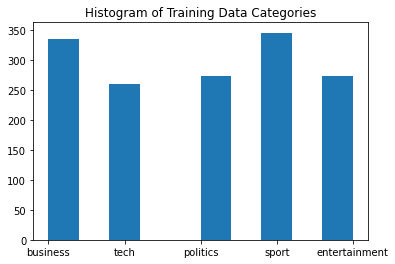

In [ ]:
plt.hist(train_df['Category'])
plt.title("Histogram of Training Data Categories")

### Word Count Histogram
We also like to inspect the word count distribution across each text to get an idea the text length in the corpus.

Text(0.5, 1.0, 'Train Set Word Count')

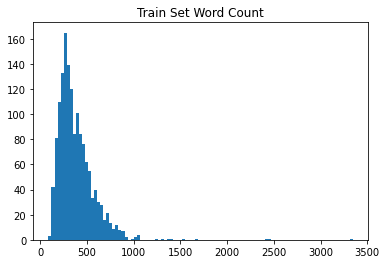

In [ ]:
train_df['count'] = train_df['Text'].str.split().str.len()
plt.hist(train_df['count'],100)
plt.title("Train Set Word Count")

Text(0.5, 1.0, 'Test Set Word Count')

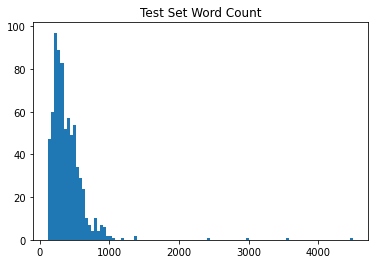

In [ ]:
test_df['count'] = test_df['Text'].str.split().str.len()
plt.hist(test_df['count'],100)
plt.title("Test Set Word Count")

### Data Cleaning

We would like to remove duplicate examples in each dataset as they won't contribute to prediction, and also perform text preprocess as most of the models to be used in this projects will perform much better with it.  The exception is BERT to be used in the supervised learning comparison, which has its own tokenization process by huggingface.  Therefore the cleaned text input is saved in a seperate column "Text_cleaned" in dataframe.

#### Remove Duplicate

In [ ]:
train_df['Text'].nunique()

1440

From above data inspection, there are 1490 unique article id in training data, but the unique texts are only 1440.  We need to perform data cleaning to remove the duplicate items

In [ ]:
train_df = train_df.drop_duplicates(subset=['Text'])
train_df

,ArticleId,Text,Category,count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301
1,154,german business confidence slides german busin...,business,325
2,1101,bbc poll indicates economic gloom citizens in ...,business,514
3,1976,lifestyle governs mobile choice faster bett...,tech,634
4,917,enron bosses in $168m payout eighteen former e...,business,355
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,223
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,558
1487,1590,weak dollar hits reuters revenues at media gro...,business,237
1488,1587,apple ipod family expands market apple has exp...,tech,560


Duplicate texts are removed.

#### Remove Stop Word, numbers, and punctuation

In the data cleaning process besides removing the duplicate documents, remove special characters in each documents I also removed stop words because they are "uninformative in representing the content of a text", and removing them is to "avoid them being construed as signal for prediction."

In [ ]:
def clean_text(series):
    '''
    A helper function which process each row of dataframe with the following steps:
    remove punctuation, numbers and stop words.
    '''
    remove_punctuation = lambda row: re.sub(r'[^\w\s]+', '', row)
    remove_numbers = lambda row: re.sub(r'[0-9]+', '', row)
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    remove_stopword = lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])
    steps = (remove_punctuation, remove_numbers, remove_stopword)
    for step in steps:
        series = series.apply(step)
    return series

In [ ]:
train_df['Text_clean'] = clean_text(train_df['Text'])
test_df['Text_clean'] = clean_text(test_df['Text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-14-e6f71fd89c6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Text_clean'] = clean_text(train_df['Text'])
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Transformation
Generate new category_id column in dataframe as labels for later part of this project, supervised learning comparisons.

In [ ]:
# create a new column containing labels in train dataframe
le = LabelEncoder()
train_df['category_id'] = le.fit_transform(train_df['Category'])

<ipython-input-15-5a17016fa638>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['category_id'] = le.fit_transform(train_df['Category'])


## Building and training models

### TF-IDF
Text Analysis using machine learning requires the input to the model not as raw text data but numerical feature vectors.  So the first step of model building and training is feature extraction from text content.  This process is also called vectorization.  There are several strategies to accompalish that, namely term frequency as feature, such as tf-idf, glove, word2vec, etc.  I am choosing tf-idf as method of text feature extraction because comparing with other methods, tf-idf is more commonly used method and is well supported by scikit-learn, a widely used ML library.  Sklearn comes with extensive utility and documentation regarding tf-idf.

The idea of tf-idf is that naive term frequency method will give some insignificant words such as the, a too much weight because their natural high occurence in English language.  To counter this, words occurs infrequently across all corpus but frequent in a partifular document are given higher weights.  For detailed guide and actual formula for tf-idf, please check out the link to sklearn user guide in the Reference section.


### NMF
NMF is a way to decompose or factor matrix X into W and H, both non-negative, and the objective is to minimize the Frobenius norm between X and W multiply by H.  The significance of the decomposition is that the resulting W contains clustering features, therefore useful in NLP text analysis such as topic extraction.

In this project, there are 5 categories in which the news articales belong.  So we set the n_component to 5 in sklearning's NMF object initialization.
The number of word features for the matrix is chosen to 2000.  The more the number of word feature, the more sophisticated word feature the matrix can represent, but it should not exceeds the number of vocabularies.

As of the question should test dataset be included in training unsupervised learning, the answer is yes because the more training dataset the model can learning from the more features the model is able to extract from, and there is no data leakage problem as in supervised learning becauses unsupervised learning don't learng from labels but from text contents.

### The NMF Model

In [ ]:
class TFIDF_NMF():
    '''The model will fit sklearn's tfidf vectorizer on corpus, then vectorize
       the input X, then a sklearn's NMF is fit with corpus and factor the X into
       W matrix, the feature matrix.
       The predict method will extract the topic/cluster features from W
    '''
    no_topics = 5

    def __init__(self, corpus, X, no_features, tuned=True):
        if tuned:
            # use tuned hyperparameters
            self.nmf = NMF(n_components=self.no_topics,
                #init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler')
                #l1_ratio = 0.5)
        else:
            self.nmf = NMF(n_components=self.no_topics)
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                           min_df=2,
                                           max_features=no_features,
                                           stop_words='english')
        tfidf_vectorizer.fit(corpus)
        tfidf = tfidf_vectorizer.transform(X)
        self.w_matrix = self.nmf.fit_transform(tfidf)

    def predict(self):
        '''return y_pred: numpy array of size (1440,), 1440 is example size in this project
           ex: array([0, 0, 0, ..., 0, 4, 4])
        '''
        y_pred = np.array([np.argmax(x) for x in self.w_matrix])
        return y_pred

In [ ]:
def get_best_y_pred_perm(y_true, y_pred, no_topics):
    """
    y_true: labels.  It has the same type and size of y_pred
    y_pred: numpy array of size (1440,), ex: array([0, 0, 0, ..., 0, 4, 4])
    Returns the best permuted label order.
    Example output: [1, 4, 1, 2, 3]
    """
    # each label id correspond to a topic/cluster
    y_pred_idx = range(no_topics)  # ex. [0,1,2,3,4]
    # get permutation of orders/index of y predictions
    # ex [[0,1,2,3,4],[1,0,2,3,4]...[4,3,2,1,0]] type: python list of list
    y_pred_idx_perms = np.array(get_perm_helper(y_pred_idx)) # ex [[0,1,2],[0,2,1]...
    max_acc = 0
    best_y_pred_perm = None
    for y_pred_idx_perm in y_pred_idx_perms:
        # Ex: if y_pred = array([0,0,2,3,2,1,...]) and y_pred_idx_perm = [0, 1, 3, 2, 4]
        # y_pred_perm would be array([0,0,3,2,3,1,...]) (only index 2 and 3 switched)
        get_perm = lambda x: y_pred_idx_perm[x]
        y_pred_perm = get_perm(y_pred) # use numpy broadcast to apply the get new perm operation to every element in y_pred
        acc = accuracy_score(y_true, y_pred_perm)
        if acc <= max_acc:
            continue
        max_acc = acc
        best_y_pred_perm = y_pred_perm
    return best_y_pred_perm

def dfs_helper(perms, perm, alist):
    '''helper function of get_perm_helper()
    '''
    if (len(alist) == len(perm)):
        perms.append(list(perm))
        return
    for n in alist:
        if n in perm:
            continue
        perm.append(n)
        dfs_helper(perms, perm, alist)
        perm.pop()

def get_perm_helper(alist):
    ''' helper function to get permutation of alist
    '''
    if alist is None or len(alist) == 0:
        return [[]]
    result = []
    dfs_helper(result, [], alist)
    return result

def evaluate(y_true, y_pred, no_topics):
    '''calculate metrics
    return accuracy, precision, recall, F1-score, and confusion matrix
    '''
    y_pred_perm = get_best_y_pred_perm(y_true, y_pred, no_topics)
    acc = accuracy_score(y_true, y_pred_perm)
    prec = precision_score(y_true, y_pred_perm, average='weighted')
    rec = recall_score(y_true, y_pred_perm, average='weighted')
    f1 = f1_score(y_true, y_pred_perm, average='weighted')
    cm = confusion_matrix(y_true, y_pred_perm)
    return acc, prec, rec, f1, cm

The training dataset for unsupervised ML model can consists data from BBC News Test.csv and BBC News Train.csv as more training samples the better performance the model is, unlike supervised model where data leak would occur.

Therefore for NMF we union the training and testing dataset into one.  Also we will use the cleaned text as corpus for NMF model.


### Model Evaluation Result

#### Training

In [ ]:
no_features = 2000
corpus = pd.concat([train_df['Text_clean'], test_df['Text_clean']])
X_train = train_df['Text_clean'].copy().values
y_train = train_df['category_id'].copy().to_numpy()
tfidf_nmf = TFIDF_NMF(corpus, X_train, no_features)
y_train_pred = tfidf_nmf.predict()
accuracy, precision, recall, f1, confusion = evaluate(y_train, y_train_pred, tfidf_nmf.no_topics)
print('accuracy =', accuracy)
print('precision =', precision)
print('recall =', recall)
print('f1 =', f1)
print('confusion_matrix =', confusion)

accuracy = 0.9423611111111111
precision = 0.946829031610041
recall = 0.9423611111111111
f1 = 0.943107575166076
confusion_matrix = [[303   1  24   1   6]
 [  2 243  12   0   6]
 [  1   2 260   0   3]
 [  0   3   7 332   0]
 [  3   3   8   1 219]]


|       | Accuracy | Precision | Recall | F1-score |
| ----------- | ----------- |  ----------- |  ----------- |  ----------- |
| Train      | 0.9541       | 0.9552 | 0.9541 | 0.9543|


|  |  |  |  |  |
| ----------- | ----------- |  ----------- |  ----------- |  ----------- |
|313 |  6 |  15 |  0|   1 |
|  2| 220|   7|   1|   4|
|  5 |  3 |256 |  1 |  1|
|  2  | 0  | 1 |337  | 2|
|  3   |5   |7  | 0 |248|



#### Testing

In [ ]:
# Get NMF prediction on test dataset to be submitted to Kaggle
test_df = test_df.copy()
X_test = test_df['Text_clean']
tfidf_nmf = TFIDF_NMF(corpus, X_test, no_features)
y_test_pred = tfidf_nmf.predict()

After submitting the result to kaggle, the received score is <mark>0.9558</mark>

### Hyperparameter Tuning

I mainly performed hyperparameter tuning on the sklearn's NMF class initializations.
The init parameter in sklearn's NMF determines the initial value of the matrix and this initialization can have big impact on the performance.  The initialization method I choose is NNDSVDa, which all zeros are set to mean of all elements.  It is better for dense matrix.  The l1_ratio default is 0, and I used 0.5, which means the ratio between L1 and L2 normalization for model regularization to counter overfit.

The solver is also changed from default Coordinate Descent to Multiplicative Update (mu) because cd can only optimize Frobenius norm and I am using Kullback-Leibler divergence.  I-divergence is used as distance function since it gives better performance, as the accuracy improved from 0.897 to 0.954

In [ ]:
# without tuned hyperparameters
X = train_df['Text_clean'].copy()
y_true = train_df['category_id'].copy().to_numpy()
tfidf_nmf = TFIDF_NMF(corpus, X, no_features, tuned=False)
y_pred = tfidf_nmf.predict()
accuracy,  precision, recall, f1, confusion = evaluate(y_true, y_pred, tfidf_nmf.no_topics)
print('accuracy=', accuracy)
print('precision =', precision)
print('recall =', recall)
print('f1 =', f1)

accuracy= 0.8895833333333333
precision = 0.9045914387257085
recall = 0.8895833333333333
f1 = 0.8889235974240348


In [ ]:
# with tuned hyperparameters
tfidf_nmf = TFIDF_NMF(corpus, X, no_features, tuned=True)
y_pred = tfidf_nmf.predict()
accuracy, precision, recall, f1, confusion = evaluate(y_true, y_pred, tfidf_nmf.no_topics)
print('accuracy=', accuracy)
print('precision =', precision)
print('recall =', recall)
print('f1 =', f1)

accuracy= 0.9423611111111111
precision = 0.946829031610041
recall = 0.9423611111111111
f1 = 0.943107575166076


|       | Accuracy | Precision | Recall | F1-score |
| ----------- | ----------- |  ----------- |  ----------- |  ----------- |
| Default      | 0.8979       | 0.9116 | 0.8979 | 0.8980|
| Tuned      | 0.9541       | 0.9552 | 0.9541 | 0.9543|

## Compare with Supervised Learning

*  I picked K-means, Logistic Regression, and BERT as supervised learning model as comparison with NMF.  Among all the supervised learning model BERT is picked as example of deep learning method.  Performance is compared on both train and test dataset.

*  The models also learn from 10%, 20%, 50% of train dataset, and performance results are recording and compared.  See the conclusion section.

In [ ]:
# evaluate each models on 90%, 50%, 20% and 10% of traing sets
test_sizes = [0.1, 0.5, 0.8, 0.9]
# for K-mean and logistic regression models
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf_vectorizer.fit(corpus)

TfidfVectorizer(max_df=0.95, max_features=2000, min_df=2, stop_words='english')

### NMF

In [ ]:
nmf_result = {'acc':[], 'prec':[], 'rec':[], 'f1':[], 'cm':[]}
for test_size in test_sizes:
    X_train, X_val, y_train, y_val = train_test_split(train_df.Text.copy().values,
                                                      train_df['category_id'].copy().values,
                                                      test_size=test_size)
    # vectorization using tfidf is already done by TFIDF_NMF init method
    tfidf_nmf = TFIDF_NMF(corpus, X_train, no_features)
    y_train_pred = tfidf_nmf.predict()
    accuracy, precision, recall, f1, confusion = evaluate(y_train, y_train_pred, tfidf_nmf.no_topics)
    nmf_result['acc'].append(accuracy)
    nmf_result['prec'].append(precision)
    nmf_result['rec'].append(recall)
    nmf_result['f1'].append(f1)
    nmf_result['cm'].append(confusion)

### K-means

In [ ]:
from sklearn.cluster import KMeans

# get K-mean model performance metrics
kmeans_result = {'acc':[], 'prec':[], 'rec':[], 'f1':[], 'cm':[]}
for test_size in test_sizes:
    X_train, X_val, y_train, y_val = train_test_split(train_df.Text.copy().values,
                                                      train_df['category_id'].copy().values,
                                                      test_size=test_size)
    # convert text input into tf-idf features embeddings
    tfidf_train = tfidf_vectorizer.transform(X_train)
    tfidf_val = tfidf_vectorizer.transform(X_val)
    kmeans = KMeans(n_clusters = 5,
                    init = 'k-means++',
                    algorithm = 'full')
    kmeans.fit_predict(tfidf_train)
    # model is trained on training set but predict on validation set
    yhat_kmean = kmeans.predict(tfidf_val)
    accuracy, precision, recall, f1, confusion = evaluate(y_val, yhat_kmean, 5)
    kmeans_result['acc'].append(accuracy)
    kmeans_result['prec'].append(precision)
    kmeans_result['rec'].append(recall)
    kmeans_result['f1'].append(f1)
    kmeans_result['cm'].append(confusion)

### Logistic Regression

In [ ]:
# get Logistic Regression model performance metrics
lr_model = LogisticRegression(C=0.25, max_iter=10000, n_jobs=-2, penalty=None,\
                              solver='saga')
lr_result = {'acc':[], 'prec':[], 'rec':[], 'f1':[], 'cm':[]}
for test_size in test_sizes:
    X_train, X_val, y_train, y_val = train_test_split(train_df.Text.copy().values,
                                                      train_df['category_id'].copy().values,
                                                      test_size=test_size)
    tfidf_train = tfidf_vectorizer.transform(X_train)
    # the model is learned from training set but make prediction on validation set
    lr_model.fit(tfidf_train, y_train)
    tfidf_val = tfidf_vectorizer.transform(X_val)
    y_pred_val = lr_model.predict(tfidf_val)
    accuracy, precision, recall, f1, confusion = evaluate(y_val, y_pred_val, 5)
    lr_result['acc'].append(accuracy)
    lr_result['prec'].append(precision)
    lr_result['rec'].append(recall)
    lr_result['f1'].append(f1)
    lr_result['cm'].append(confusion)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


### BERT


In [ ]:
#huggingface implementation of transformer (BERT) in pytorch
class BERT():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __init__(self, X_train, y_train, X_val, y_val, batch_size):
        self.dataloader_train = self.get_dataloader(X_train, y_train)
        self.dataloader_val = self.get_dataloader(X_val, y_val)

    def get_dataloader(self, X, y):
        encoded_data = self.tokenizer.batch_encode_plus(
            X,
            add_special_tokens=True,
            #return_attention_mask=True,
            padding='max_length',
            truncation = True,
            max_length=512,
            return_tensors='pt'
        )
        # use corresponding tokenizer to convert text input to tokens that model can recognize
        # input_ids, attention_masks, labels are required model inputs
        input_ids = encoded_data['input_ids']
        attention_masks = encoded_data['attention_mask']
        labels = torch.tensor(y)
        dataset = TensorDataset(input_ids, attention_masks, labels)
        return DataLoader(dataset,
                              sampler=RandomSampler(dataset),
                              batch_size=batch_size)

    def compile(self, epochs):
        ''' setup training parameters such as learning rate, optimizer, etc
        '''
        self.epochs = epochs
        self.optimizer = AdamW(self.model.parameters(),
              lr=1e-5,
              eps=1e-8)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(self.dataloader_train)*epochs)

    def train(self):
        ''' traing model on train dataset
        '''
        for epoch in tqdm(range(1, self.epochs+1)):
            self.model.train()
            loss_train_total = 0
            progress_bar = tqdm(self.dataloader_train,
                                desc='Epoch {:1d}'.format(epoch),
                                leave=False, disable=False)
            for batch in progress_bar:
                self.model.zero_grad()
                batch = tuple(b.to(self.device) for b in batch)
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'labels':         batch[2],
                        }
                self.model = self.model.to(self.device)
                outputs = self.model(**inputs)
                loss = outputs[0]
                loss_train_total += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()
                progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    def predict(self):
        '''predict on validation dataset
        '''
        self.model.eval()
        predictions, true_vals = [], []
        for batch in self.dataloader_val:
            batch = tuple(b.to(self.device) for b in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[2],
                    }
            with torch.no_grad():
                self.model = self.model.to(self.device)
                outputs = self.model(**inputs)
            loss = outputs[0]
            logits = outputs[1]
            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        return np.argmax(predictions, axis=1).flatten(), true_vals.flatten()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# train BERT and get model performance metrics
batch_size = 3
epoch = 2
bert_result = {'acc':[], 'prec':[], 'rec':[], 'f1':[], 'cm':[]}

for test_size in test_sizes:
    X_train, X_val, y_train, y_val = train_test_split(train_df.Text.copy().values,
                                                      train_df['category_id'].copy().values,
                                                      test_size=test_size)
    model_bert = BERT(X_train, y_train, X_val, y_val, batch_size)
    model_bert.compile(epoch)
    model_bert.train()
    y_pred_val, y_val = model_bert.predict()
    accuracy, precision, recall, f1, confusion = evaluate(y_val, y_pred_val, 5)
    bert_result['acc'].append(accuracy)
    bert_result['prec'].append(precision)
    bert_result['rec'].append(recall)
    bert_result['f1'].append(f1)
    bert_result['cm'].append(confusion)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/432 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/432 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/240 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/48 [00:00<?, ?it/s]

### Result Comparison

In [ ]:
# NMF
pd.DataFrame(nmf_result)

,acc,prec,rec,f1,cm
0,0.949074,0.950451,0.949074,0.949245,"[[276, 1, 17, 2, 5], [3, 229, 7, 0, 6], [3, 2,..."
1,0.951389,0.951853,0.951389,0.951496,"[[156, 0, 4, 0, 4], [2, 118, 3, 0, 3], [2, 1, ..."
2,0.920139,0.932905,0.920139,0.922962,"[[57, 0, 3, 0, 4], [0, 52, 0, 0, 6], [1, 0, 48..."
3,0.750000,0.757786,0.750000,0.743736,"[[37, 0, 1, 0, 4], [0, 21, 0, 1, 2], [1, 0, 15..."


In [ ]:
# K-means
pd.DataFrame(kmeans_result)

,acc,prec,rec,f1,cm
0,0.791667,0.862569,0.791667,0.796804,"[[24, 0, 1, 0, 4], [1, 15, 0, 1, 12], [2, 0, 1..."
1,0.827778,0.887340,0.827778,0.823718,"[[162, 0, 1, 0, 3], [75, 55, 0, 2, 0], [22, 0,..."
2,0.655382,0.875579,0.655382,0.690254,"[[110, 0, 2, 1, 141], [0, 101, 0, 0, 110], [1,..."
3,0.591049,0.684548,0.591049,0.575279,"[[117, 0, 173, 5, 5], [93, 100, 1, 43, 0], [39..."


In [ ]:
# Logistic Regression
pd.DataFrame(lr_result)

,acc,prec,rec,f1,cm
0,0.986111,0.986759,0.986111,0.986094,"[[37, 0, 1, 0, 1], [0, 28, 0, 0, 0], [0, 0, 28..."
1,0.955556,0.955735,0.955556,0.955589,"[[151, 1, 4, 0, 4], [3, 130, 2, 0, 0], [6, 1, ..."
2,0.948785,0.949187,0.948785,0.948690,"[[252, 1, 7, 1, 5], [2, 204, 3, 5, 6], [5, 1, ..."
3,0.922840,0.924493,0.922840,0.922894,"[[286, 1, 7, 1, 6], [5, 216, 10, 3, 4], [7, 0,..."


In [ ]:
# BERT
pd.DataFrame(bert_result)

,acc,prec,rec,f1,cm
0,0.951389,0.951946,0.951389,0.951329,"[[33, 0, 2, 0, 2], [0, 31, 0, 0, 0], [0, 0, 22..."
1,0.991667,0.991682,0.991667,0.991659,"[[151, 0, 1, 0, 2], [0, 135, 0, 0, 0], [1, 0, ..."
2,0.993924,0.994020,0.993924,0.993923,"[[264, 0, 1, 0, 5], [0, 202, 0, 0, 0], [0, 0, ..."
3,0.994599,0.994659,0.994599,0.994600,"[[293, 0, 1, 0, 4], [0, 243, 1, 0, 0], [0, 0, ..."


### Conclusion

*  The performance metrics used for model evaluation are accuracy, precision, recall, f1-score, and confusion matrix.  From the result table we can see among all models the metrics are pretty close, as we expected because from the data inspection visualization we can see the classes are balanced.  Therefore in the following discussion I will mainly use accuracy as performance metric.

*  If we look at the accuracy of the models only on 90% of training sets, the order of performance in descending order is fowlloing:
BERT, logistic regression, NMF, k-means.
This is as what we expected because BERT, a transformer model, use deep learning to learn very complex linguistic patterns in the text and therefore can generate more accurate classification result whereas the other algorithms use bag of word embedding method which only take account of word frequency, not contextual semantic as BERT does.  In general, deep learning models with large dataset performs better.

*  If we look at the accuracy on the 10% training set performance, the order in descending is the same as above, which is a little suprising as I expect to see unsupervised learning method such as NMF's performance would surpass the rest, especially deep learning as more complex model would easily overfit on small training datasets but I think the reason we got contrary result is because we used pretrained BERT model, which is already capable of extracting complex features from english text.


# Reference:

https://www.kaggle.com/code/ahmedabdulhamid/bbc-sentimentclassification-ml-bert

https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction